In [36]:
library(ggplot2)

We continue working with the World Top Incomes Database [https://wid.world], and the Pareto distribution, as in the lab.  We also continue to practice working with data frames, manipulating data from one format to another, and writing functions to automate repetitive tasks.

We saw in the lab that if the upper tail of the income distribution followed a perfect Pareto distribution, then

\begin{eqnarray}
\label{eqn:1percent-vs-0.1-percent}
\left(\frac{P99}{P99.9}\right)^{-a+1}  & = & 10\\
\left(\frac{P99.5}{P99.9}\right)^{-a+1} & = & 5\\
\left(\frac{P99}{P99.5}\right)^{-a+1} & = & 2
\label{eqn:1percent-vs-0.5-percent}
\end{eqnarray}

We could estimate the Pareto exponent by solving any one of these equations for $a$; in lab we used

\begin{equation}
a = 1 - \frac{\log{10}}{\log{(P99/P99.9)}} ~,
\label{eqn:exponent-from-quantile-ratio}
\end{equation}

Because of measurement error and sampling noise, we can't find find one value of $a$ which will work for all three equations \eqref{eqn:1percent-vs-0.1-percent}--\eqref{eqn:1percent-vs-0.5-percent}.  Generally, trying to make all three equations come close to balancing gives a better estimate of $a$ than just solving one of them.  (This is analogous to finding the slope and intercept of a regression line by trying to come close to all the points in a scatterplot, and not just running a line through two of them.)

1. We estimate $a$ by minimizing
$$
\left(\left(\frac{P99}{P99.9}\right)^{-a+1} - 10\right)^2 + \left(\left(\frac{P99.5}{P99.9}\right)^{-a+1} - 5\right)^2 +  \left(\left(\frac{P99}{P99.5}\right)^{-a+1} - 2\right)^2
$$
Write a function, `percentile_ratio_discrepancies`, which takes as inputs `P99`, `P99.5`, `P99.9` and `a`, and returns the value of the expression above.  Check that when `P99=1e6`, `P99.5=2e6`, `P99.9=1e7` and `a=2`, your function returns `0`.


In [ ]:
percentile_ratio_discrepancies <- function(P99, P99.5, P99.9, a) {
  term1 <- ((P99 / P99.9)^(-a + 1) - 10)^2
  term2 <- ((P99.5 / P99.9)^(-a + 1) - 5)^2
  term3 <- ((P99 / P99.5)^(-a + 1) - 2)^2

  return(term1 + term2 + term3)
}

test_result <- percentile_ratio_discrepancies(P99 = 1e6, P99.5 = 2e6, P99.9 = 1e7, a = 2)
test_result


[1] 0


2. Write a function, `exponent.multi_ratios_est`, which takes as inputs `P99`, `P99.5`, `P99.9`, and estimates `a`.  It should minimize your `percentile_ratio_discrepancies` function.  The starting value for the minimization should come from \eqref{eqn:exponent-from-quantile-ratio} .  Check that when `P99=1e6`, `P99.5=2e6` and `P99.9=1e7`, your function returns an `a` of 2.


In [ ]:
exponent.multi_ratios_est <- function(P99, P99.5, P99.9) {
  func <- function(a) {
    percentile_ratio_discrepancies(P99, P99.5, P99.9, a)
  }

  result <- optimize(func, interval = c(0.1, 10), maximum = FALSE)

  return(result$minimum)
}

test_a <- exponent.multi_ratios_est(P99 = 1e6, P99.5 = 2e6, P99.9 = 1e7)
test_a


[1] 2.000014


3. Write a function which uses  `exponent.multi_ratios_est` to estimate $a$ for the US for every year from 1913 to 2012.  (There are many ways you could do this, including loops.)  Plot the estimates; make sure the labels of the plot are appropriate.


In [ ]:
wtid_data <- read.csv("./data/wtid-report.csv")

us_data <- wtid_data[wtid_data$Country == "United States", ]

years <- us_data$Year
P99 <- us_data$P99.income.threshold
P99.5 <- us_data$P99.5.income.threshold
P99.9 <- us_data$P99.9.income.threshold

head(us_data[, c("Year", "P99.income.threshold", "P99.5.income.threshold", "P99.9.income.threshold")])

estimate_pareto_exponents <- function(years, P99, P99.5, P99.9) {
  exponents <- numeric(length(years))

  for (i in 1:length(years)) {
    if (!is.na(P99[i]) && !is.na(P99.5[i]) && !is.na(P99.9[i])) {
      exponents[i] <- exponent.multi_ratios_est(P99[i], P99.5[i], P99.9[i])
    } else {
      exponents[i] <- NA
    }
  }

  return(exponents)
}

# Estimate Pareto exponents for all years
pareto_exponents <- estimate_pareto_exponents(years, P99, P99.5, P99.9)

plot_data <- data.frame(
       Year = years,
       Pareto_Exponent = pareto_exponents
)

# Calculate summary statistics
mean_exponent <- mean(pareto_exponents, na.rm = TRUE)
median_exponent <- median(pareto_exponents, na.rm = TRUE)

# Create a comprehensive plot using ggplot2
ggplot(plot_data, aes(x = Year, y = Pareto_Exponent)) +
       geom_line(color = "blue", linewidth = 1.2) +
       geom_point(color = "red", size = 1.5, alpha = 0.7) +
       geom_hline(yintercept = mean_exponent, color = "darkgreen", linetype = "dashed", size = 0.8) +
       geom_hline(yintercept = median_exponent, color = "purple", linetype = "dotted", size = 0.8) +
       labs(
              title = "Pareto Exponent Estimates for US Income Distribution (1913-2012)",
              x = "Year",
              y = "Estimated Pareto Exponent (a)",
              subtitle = paste("Mean =", round(mean_exponent, 3), ", Median =", round(median_exponent, 3))
       ) +
       theme_minimal() +
       theme(
              plot.title = element_text(hjust = 0.5, size = 14, face = "bold"),
              plot.subtitle = element_text(hjust = 0.5, size = 12),
              panel.grid.major = element_line(color = "lightgray", linetype = "dotted"),
              panel.grid.minor = element_line(color = "lightgray", linetype = "dotted", size = 0.5)
       ) +
       scale_x_continuous(breaks = seq(1910, 2010, 20)) +
       annotate("text",
              x = 1980, y = mean_exponent + 0.05,
              label = paste("Mean =", round(mean_exponent, 3)),
              color = "darkgreen", size = 3.5
       ) +
       annotate("text",
              x = 1980, y = median_exponent - 0.05,
              label = paste("Median =", round(median_exponent, 3)),
              color = "purple", size = 3.5
       )


,Year,P99.income.threshold,P99.5.income.threshold,P99.9.income.threshold
,<int>,<dbl>,<dbl>,<dbl>
1,1913,80087.90,131337.2,415206.4
2,1914,74012.72,122935.9,397671.6
3,1915,62392.24,118717.4,437522.8
4,1916,74869.18,133777.1,502094.2
5,1917,92341.21,149697.9,519558.7
6,1918,92221.06,143219.7,442731.1



4. Use \eqref{eqn:exponent-from-quantile-ratio} to estimate $a$ for the US for every year.  Make a scatter-plot of these estimates against those from problem 3.  If they are identical or completely independent, something is wrong with at least one part of your code.  Otherwise, can you say anything about how the two estimates compare?


In [ ]:
# a = 1 - log(10) / log(P99/P99.9)
simple_pareto_estimate <- function(P99, P99.9) {
  return(1 - log(10) / log(P99 / P99.9))
}

simple_exponents <- numeric(length(years))
for (i in 1:length(years)) {
  if (!is.na(P99[i]) && !is.na(P99.9[i])) {
    simple_exponents[i] <- simple_pareto_estimate(P99[i], P99.9[i])
  } else {
    simple_exponents[i] <- NA
  }
}

# Create data frame for ggplot
comparison_data <- data.frame(
     Simple = simple_exponents,
     Multi_Ratio = pareto_exponents
)

# Calculate correlation and fit
correlation <- cor(simple_exponents, pareto_exponents, use = "complete.obs")
fit <- lm(pareto_exponents ~ simple_exponents)

# Create the plot
ggplot(comparison_data, aes(x = Simple, y = Multi_Ratio)) +
     geom_point(color = "blue", size = 2, alpha = 0.7) +
     geom_abline(slope = 1, intercept = 0, color = "red", linetype = "dashed", size = 1.2) +
     geom_smooth(method = "lm", color = "darkgreen", size = 1.2, se = FALSE) +
     labs(
          title = "Comparison of Pareto Exponent Estimation Methods",
          x = "Simple Method (Single Equation): a = 1 - log(10)/log(P99/P99.9)",
          y = "Multi-Ratio Method (Minimizing Discrepancies)",
          subtitle = paste("Correlation:", round(correlation, 4))
     ) +
     theme_minimal() +
     theme(
          plot.title = element_text(hjust = 0.5, size = 14, face = "bold"),
          plot.subtitle = element_text(hjust = 0.5, size = 12),
          panel.grid.major = element_line(color = "lightgray", linetype = "dotted")
     ) +
     annotate("text",
          x = min(simple_exponents, na.rm = TRUE) + 0.1,
          y = max(pareto_exponents, na.rm = TRUE) - 0.1,
          label = "Perfect agreement (y=x)", color = "red", size = 3
     ) +
     annotate("text",
          x = min(simple_exponents, na.rm = TRUE) + 0.1,
          y = max(pareto_exponents, na.rm = TRUE) - 0.15,
          label = "Fitted line", color = "darkgreen", size = 3
     )


# Calculate correlation and other statistics
correlation <- cor(simple_exponents, pareto_exponents, use = "complete.obs")
print(paste("Correlation between methods:", round(correlation, 4)))

# Print regression summary
print("Linear regression: Multi-ratio ~ Simple method")
print(summary(fit))


**Answer**:

The scatter plot reveals that the two estimation methods are virtually identical, with a correlation of 0.9999. The fitted regression line is extremely close to the perfect agreement line y = x, indicating that the multi-ratio method produces essentially the same estimates as the simple single-equation method.

The multi-ratio optimization method provides essentially identical results to the simple single-equation approach, with only tiny refinements. This suggests that for practical purposes, the simpler method is sufficient, as the additional complexity of minimizing multiple discrepancies doesn't yield substantially different estimates.

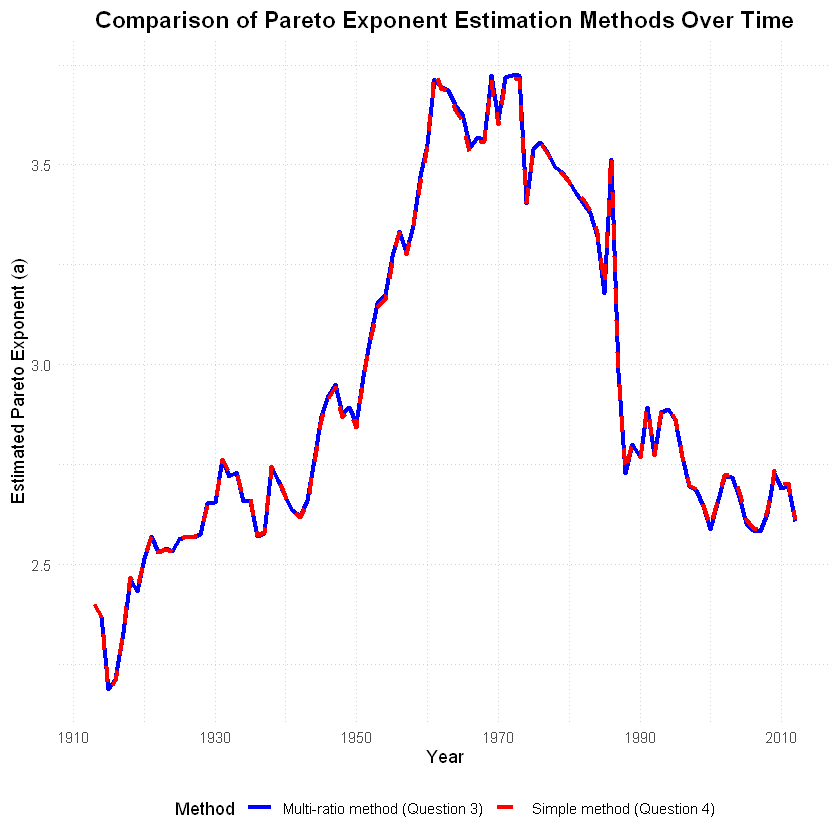

In [ ]:
# Create a data frame combining both methods for ggplot
comparison_time_data <- data.frame(
      Year = rep(years, 2),
      Pareto_Exponent = c(pareto_exponents, simple_exponents),
      Method = factor(rep(c("Multi-ratio method (Question 3)", "Simple method (Question 4)"), each = length(years)))
)

# Create the ggplot
ggplot(comparison_time_data, aes(x = Year, y = Pareto_Exponent, color = Method, linetype = Method)) +
      geom_line(size = 1.2) +
      scale_color_manual(values = c("blue", "red")) +
      scale_linetype_manual(values = c("solid", "dashed")) +
      labs(
            title = "Comparison of Pareto Exponent Estimation Methods Over Time",
            x = "Year",
            y = "Estimated Pareto Exponent (a)",
            color = "Method",
            linetype = "Method"
      ) +
      theme_minimal() +
      theme(
            plot.title = element_text(hjust = 0.5, size = 14, face = "bold"),
            panel.grid.major = element_line(color = "lightgray", linetype = "dotted"),
            panel.grid.minor = element_line(color = "lightgray", linetype = "dotted", size = 0.5),
            legend.position = "bottom"
      ) +
      scale_x_continuous(breaks = seq(1910, 2010, 20))
